# <center>OpenAI在线大模型调用及微调方法

## <center>Ch.17.1 OpenAI Embedding模型 API 使用指南

In [11]:
import numpy as np
import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

&emsp;&emsp;从本节开始，我们将正式进入到Embedding这一全新的技术领域中。

- 当下大语言模型知识库局限性

&emsp;&emsp;在之前的课程中我们曾多次提到：尽管大语言模型具备庞大和丰富的知识，其知识量远超个人能掌握的知识范畴且具备非常强大的涌现能力，但在实际应用中，我们仍然能明显感觉到**大模型在“时效性”和“专业性”这两方面的局限**。所谓"时效性"，指的是大模型的**原生能力**无法获取到最新的知识，比如你问它今天的天气怎么样，它是不知道的， 而“专业性”，指的是它在**原生能力**下，不能回答出非常专业的知识，比如你想让它回答出你们学校的规章制度，公司的审批流程等，它也没办法精准的回答出来。

&emsp;&emsp;无论是大模型在其**原生能力**下的时效性信息缺失还是专业领域知识匮乏，其背后的根本原因是受限于大模型本身的训练机制，即大模型的知识库只能够在预训练时才会被更新，在预训练阶段输入的数据量决定了大模型的知识边界。就目前情况来说，大模型的预训练仍然既复杂，成本又极高，据相关人员的统计显示，**一次大模型的预训练成本约在200万美元到1200万美元之间，同时背后还需要大量的算力支持**。这就使得普通企业来做大模型的预训练，几乎是不可能的事情。而业内发布的大语言模型都是阶段性才推出新版本的模型（例如GPT4、ChatGLM3），只有新版本的推出才意味着其知识库的更新，基于上述提到的种种原因，大模型的知识库通常落后于当前时间一段时间，这点对于国内开源大模型来说尤为明显。

- 国内外大模型知识库时效性与专业性问题

&emsp;&emsp;当然围绕时效性问题，作为大模型技术领先的科技公司，OpenAI和Google也一直在试图解决该问题。截止目前，OpenAI发布的GPT-4-Turbo模型和谷歌最新发布的Gemini模型，均大幅更新了知识库截止时间，相比GPT-4和PaLM2模型知识库截止到2021年9月，新版GPT-4-Turbo和Gemini模型的知识库截止时间均为2023年4月：

In [3]:
response = openai.ChatCompletion.create(
  model="gpt-4-1106-preview",
  messages=[
    {"role": "user", "content": "你的知识库截止到什么时间？"}
  ]
)
response.choices[0].message['content']

'我的知识库的信息截止到2023年的3月。如果您有任何问题，无论是历史信息还是截至该日期的最新事件，我都会尽力为您提供帮助。请告诉我您想知道的具体信息。'

In [7]:
model = GenerativeModel("gemini-pro")
response = model.generate_content('你的知识库截止到什么时间？')
print(response.text)

我的知识库截止到 2023 年 4 月。之后发生的事情不在我的知识范围内。但是，我一直在不断学习和更新，希望在不久的将来能赶上最新的知识。


在可以预计的未来，OpenAI和Google的在线大模型仍将在大模型知识库时效性上不断发力，力求缩短时效性差距。

&emsp;&emsp;但是相比之下，国内普遍使用的开源大模型时效性仍然停留在，与国外的在线大模型还有一定的差距。

当然，哪怕大模型知识库“时效性”问题被一定程度缓解，“专业性”的挑战恐怕依然会存在。由于企业和组织的内部文件通常仅限于特定人员在特定环境下使用，这些数据的私密性和敏感性意味着它们不会被公开，从而无法被大模型学习和吸收。因此，即使大模型能够接入最新信息，没有权限获取这些专有数据，它们也无法获得特定领域的深度知识。而这也将极大程度影响大模型的Agent表现。

- 大模型知识库决定Agent应用效果

&emsp;&emsp;而无论是大模型知识库的时效性问题还是专业性问题，都会很大程度影响大模型技术应用落地效果。时至今日，围绕大模型的AI应用愈发朝向解决特定领域的特定工作方向发展（大模型本身也逐渐成为一项基础设施），而在搭建某特定领域的Agent时，如何将本地知识库（尤其是特定领域知识库）接入Agent就成了首当其冲需要解决的问题。例如对于此前课程中介绍的MateGen，尽管其已经具备了非常完整的复杂任务拆解、联网、代码解释器以及自动debug功能，但若要将其应用于某个特定领域，仍然还是要输入特定领域的知识，例如如果希望使用MateGen进行“电信用户流失预测分析”，那么则需要输入与之相关的业务说明和数据库字典，而如果是希望借助MateGen完成机器学习建模，则需要输入一些公司（团队）常用建模流程代码、特征工程方法代码库、模型融合方法代码库等（而如果是竞赛场景中，则需要输入赛题背景以及高分Kernel等），才能更好引导MateGen创造令人满意的建模结果。

- 大模型输入外部知识方法            
    
    &emsp;&emsp;而要如何才能为大模型输入特定领域的额外知识呢？经过一段时间的技术探索，除了从零训练大模型之外，目前来说有如下几种行之有效的策略可以为大模型输入定制知识库：
    
    1) 将外部知识作为System Message进行整体输入：这也是最简单快捷的一种方式，并且也是最稳定的让大模型接收到外部信息的方法，几乎没有任何的损耗，这也是此前我们为大模型或Agent输入专家文档或数据库字典的方法。但这种方式的本质其实是在每次（单次）对话的时候都输入这些“背景信息”，以确保模型能够基于这些“背景信息”进行回答，而受限于单次对话的最大上下文限制，每次输入的背景信息都是有限的，因此对于某些长文本的背景信息（例如上市公司财报），往往是无法直接输入的。截止目前，主流大模型均以16K或者32K作为最大上下文对话限制，约1.5页（16K）或3页（32K）标准PDF长度。很明显，很多知识库文档的内容长度都远超这个长度；
    > 当然，另一个非常明显的大模型技术迭代方向就是朝着越来越长的对话上下文限制进行迭代，最新发布的GPT-4-Turbo达到了惊人的128K，这也为外部知识库输入带来了极大的便利。
    
    2) 借助Embedding实现短文本匹配：既然有些过长的外部知识库文本无法一次性输入，那能否“曲线救国”，将长文本拆分成一个个短文本，然后在每次问答的时候，都将与问题最相关的短文本进行输入呢？答案是可以的，并且这也是目前最为通用的、同时也是最适用于国内开源大模型的长文本输入方法。当然，该方案涉及到两个核心的技术难点，其一是如何将一个长文本拆分为一组短文本、其二则是如何在提问的时候将与之最相关的短文本进行输入。关于长文本拆分成短文本的方法，很多时候都需要根据实际文本情况来决定，我们会随着课程进展不断为大家介绍适用于各种文本拆分的方法，而如何将短文本和问题进行匹配，所涉及到的核心技术就是Embedding（词向量映射），也是本节将要重点介绍的技术内容。当然，既然是将长文本拆分为短文本，那就必然会带来一定的信息损失，因此这种长文本信息输入的过程也有一定的性能局限性。
    <center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20231218181159789.png" alt="image-20231218181159789" style="zoom:33%;" /></center>         
        
    
    3) 借助LangChain实现长文本读取：有趣的是，一旦当某项技术成为一项业内通用的技术规范，或者某项需求成为普遍需求，那么就会诞生服务于（加速）这项技术应用的技术范式诞生。例如当围绕长文本的信息获取成为最广泛的大模型技术应用及Agent开发需求的时候，能够快速读取长文本信息的Agent开发范式也随之诞生。截至目前，开源框架LangChain能够实现基于开源模型的长文本信息输入，能够全自动的进行长文本切分与短文本匹配，并且还进一步诞生了基于LangChain的ChatChat项目，专门用于实现更加精准的短文本拆分与匹配，该项目的拆分匹配流程如下：        
    <center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20231218182814731.png" alt="image-20231218182814731" style="zoom:33%;" /></center>        
    4) 借助Assistant API实现长文本读取：而另一个专门用于GPT模型Agent开发的框架——由OpenAI推出的Assistant API，则提供了更加简单粗暴的长文本读取解决方案，即OpenAI提供了一整套在线文件系统（OpenAI File System），允许用于存储多种类型的、大小不一的文件，而任意一个基于Assistant API开发的Agent，都可以无损接入OpenAI File System，实现任意长文本读取。
    5) 借助大模型微调进行知识灌注：最后一个策略则是通过微调来进行知识灌注。正如课程预习视频中所提到的，大模型微调可以修改一部分模型参数，从而模型根本性的记住某些信息。尽管“让模型永久的记住某些信息”听起来非常诱人，但实际上微调的技术门槛和风险都非常高，就目前大模型技术应用情况来看，哪怕是经验非常丰富的大模型工程师，也很难保证围绕每个不同类型的知识库，都能在确保原始知识不被大规模遗忘的情况下，微调得到还不错的结果。实际上，大模型微调只能在一些特定领域、一些相对固定的问答情景中才能微调获得一个较好的结果，关于微调技术，我们将在后续的课程中再进行深度探讨

> **“Embedding”这个词很难有一个准确的中文释义，很多人尝试将其直译为“嵌入”或“向量映射”，但这些译名似乎并不能完全捕捉其真实含义。因此，在本节的内容中我们还是沿用原名“Embedding”。**

- 大模型本地知识库解决方案总结

| 解决方案 | 优势 | 局限 |
| :-----: | :------: | :-----: |
| 以System message的形式输入外部文本  |  无损输入外部文件信息   |   受限于模型最大对话上线文限制 |
| 切分文本，并以Embedding方法进行匹配  |  灵活高效，适用于各种情况   |   有一定的技术门槛，且信息输入有损耗 |
| 借助LangChain实现长文本读取  |  灵活高效，技术门槛低   | 存在信息损耗，文本切分与匹配方法单一 |
| 借助Assistant API实现长文本读取  |  近乎无损读取海量文档  | 只能使用OpenAI在线存储服务，以及只能使用GPT模型进行读取 |
| 借助大模型微调进行知识灌注  |  可以让大模型永久记住某些信息  | 技术门槛较高，容易造成灾难性遗忘 |

- 大模型技术领域Embedding技术应用前景

&emsp;&emsp;需要注意的是，尽管有非常多种本地知识库问答解决方案，但手动进行长文本切分、并且进行短文本匹配，却是每个大模型技术人的必修课。原因有二：其一是截止目前，并没有哪个Agent开发框架能够非常好的近乎无损的输入长文本信息（除Assistant API外），并且每个Agent应用领域各不相同，往往需要结合具体知识库情况进行长文本输入策略的调整，因此手动切分长文本并进行匹配可能是围绕当前具体问题去获得最好文本输入效果的策略，对于（无法使用Assistant API的）国内大多使用开源大模型的技术生态来说更是如此；其二则是除了短文本匹配之外，Embedding技术还可以用于例如文档（或表格）标题匹配等技术场景，大多数时候文档（或表格）的匹配技术难度不高，而这种分层匹配的流程却能够大幅降低长文本信息获取难度（否则就只能将一系列长文本拼接到一起再进行）。因此无论从哪个角度来看，为了能够更好的解决长文本的输入问题，Embedding技术都是大模型工程师的必修课。

- Embedding技术框架与Embedding部分课程设计

&emsp;&emsp;尽管很多同学是通过大模型技术才接触到Embedding技术，但实际上，作为NLP技术领域的一种非常通用的技术类型，Embedding发展至今已经形成了非常庞大的技术架构群，哪怕是通用的Embedding架构也有数十种之多，可以按照动态或者静态Embedding方法进行划分，或者也可以按照Embedding背后的预训练模型进行划分。在大模型课程中，我们将重点关注那些能够帮我们更好的完成外部只是库输入的Embedding框架，并重点探讨围绕大模型Agent开发的相关Embedding方法的使用。

&emsp;&emsp;基于此，课程中的Embedding内容将分两部分进行介绍，本着向最前沿技术学习的思路，Embedding模块的第一部分将重点介绍OpenAI的在线Embedding模型，顾名思义这类Embedding模型是由OpenAI提供的在线Embedding模型，和GPT系列模型类似，根据调用情况进行收费（当然经过数次调价，目前OpenAI的Embedding模型价格已经非常低了），并且能够完美适配GPT系列模型；而第二部分，则将进一步介绍开源的Embedding模型框架，以适配与开源模型的长文本匹配情景。相比之下，OpenAI的Embedding模型性能稳定且调用简单，而开源的Embedding框架则上手难度会更大。

- OpenAI Embedding部分内容划分

&emsp;&emsp;OpenAI Embedding部分内容中，首先将详细介绍Embedding的基础知识，帮助大家理解文本向量化的过程，继而，我们会全面解析OpenAI的Embedding模型，包括其调用方式和对应参数的应用技巧。最后，我们将和大家共同完成零样本分类、聚类分析等六个非常典型的Embedding应用案例，从而加深大家对Embedding应用的理解，此外，为了让大家能够在实际工作、学习中运用所学知识，我们还准备了四个企业级应用实践，包括大文本的批量Embedding处理、自定义Embedding维度优化、利用Embedding实现海量文本匹配及大数据集的文本相似度分析。通过这些实践，我们希望帮助大家彻底掌握Embedding及其应用方法，切身体验到Embedding在实际应用场景中的巨大价值。

##  一、Embedding基础：理解文本向量化

### 1.Embedding基本概念入门

&emsp;&emsp;接下来，我们首先需要了解一下Embedding词向量化到底是什么。

#### 1.1 Embedding：自然语言在计算机世界的投影

&emsp;&emsp;从最终的结果来看，所谓的文本的Embedding，其实就是将原先的自然语言符号转化为一个高维数组。我们都知道，从本质上来说，计算机识别0/1二进制代表的对象，而无法直接理解自然语言的含义。因此，要让计算机识别语句含义（主要是语句之间的语义关联性），则需要将原本的自然语言投射到一个高维空间，并用一个数组对其进行表示。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/image-20231027153920966.png" width='1000'></div>

> 计算机只能够识别二进制数据，即0和1的序列。但是，它可以通过特定的二进制编码方案来表示和处理浮点数（即带小数点的数）。这种编码方案通常遵循一种称为IEEE浮点数标准的规则。

其实不仅仅是Embedding，我们对于任何事物的认识，其实也都是源于一些维度的信息，例如，例如我们对一个人的认识可以有如下一些角度（维度）：
- 粗粒度：性别、年龄、外貌、性格等；
- 细粒度：身高、体重、头发长短、是否有单双眼皮；

&emsp;&emsp;人类凭借感官和直觉可以轻松地识别和区分个体之间的差异，这种能力对我们来说几乎是本能的。但如果想让计算机执行同样的识别任务，情况就会变得复杂。计算机没有感官，它们依赖于算法和数据处理来模拟这一过程。因为计算机只能识别和处理二进制数据，那么我们可以将一个人表示为[30岁,身高180cm, 体重70kg]，在这里，**每个特征代表一个维度，比如年龄、身高、体重，在数学上我们可以称之为“多维”，而年龄、身高和体重这样的特征可以在一个连续的范围内取值，比如年龄可以是任意一个实数，在数学上我们可以称之为“连续的”。从而我们就可以这样理解：包含多个特征的这个列表，叫做多维空间，描述这个人特征的这一串数字，叫做连续向量。所以一个人在计算机中的表示，就是一个多维空间的连续向量。** 例如在极简情况下，我们假设某人[30岁,身高180cm, 体重70kg]的表示如下，这里的p1就是这个人在计算机世界里的高维信息投射：

In [7]:
p1 = np.array([30, 180, 70])

#### 1.2 基于Embedding的相似度挖掘

&emsp;&emsp;不同于人类拥有一些天然的基于某些规则的客观的评判标准，计算机对于样本空间中的点的认识源于不同点之间的相互关系。例如基于某些评判标准，我们会认为28岁、180cm、200kg的人的体重过重，而35岁、170、75kg的体重则相对正常。但对于计算机来说，以上三个人的信息都只是当前样本空间中的三个点，而在初始情况下，计算机并不能判断谁的体重超标，而只能简单判断哪些样本点之间的关联性更大。然后再在基于外部规则的情况下，将关联性结果转化为更有针对性的结论。这里我们先将刚才所说的两个人的基本情况转化为样本空间中的另外两个点：

In [8]:
p2 = np.array([28, 180, 200])
p3 = np.array([35, 175, 75])

**要看两个人或两段文本的是否是相似的，我们可以比较它们的这个多维空间中的连续向量。这种比较通常是通过计算向量间的距离来实现的（比如测量这个空间中两点之间的直线距离），距离越小，表明两个向量在多维空间中越接近，即这两个人或文本在多个特征上更相似，从而实现最相似的文本匹配。这种基于距离的比较就是量化相似度的关键。因此，整体向量的相似度可以看作是在多个维度上特征相似性的综合体现。这就是所谓的Embedding**，它是一种将文本转换为多维空间中的连续向量的方法，通过计算这些点之间的距离来判断文本之间的相似性。距离越近表示两段文本越相似，距离越远则意味着它们的差异越大。

In [9]:
# 计算距离
distance_p1_p2 = np.linalg.norm(p1 - p2)
distance_p1_p3 = np.linalg.norm(p1 - p3)
distance_p2_p3 = np.linalg.norm(p2 - p3)

distance_p1_p2, distance_p1_p3, distance_p2_p3

(130.01538370516005, 8.660254037844387, 125.29565036345036)

此时计算机能够判断p2与p1、p3相距较远，可能存在异常情况。

&emsp;&emsp;而实际上，当我们在使用Embedding对文本进行词向量化处理的时候，也是将其先投射到高维空间，然后再文本之间的距离，并根据距离远近进行相似度匹配。只不过面对茫茫多的单次、句子、段落，为表示它们的语义，需要在高维空间表示其含义，这个在高维空间投射过程远比我们上面看到的只通过三个维度来统计各人信息要复杂的多。

&emsp;&emsp;接下来，我们先从Embedding的鼻祖、也是大家相对更加熟悉的One-hot独热编码开始介绍，One-Hot是文本词向量化早期尝试的方法，而促使Embedding技术出现的原因，也主要是为了解决One-Hot编码存在的限制和不足。

### 2.One-Hot编码：文本向量化的早期尝试

&emsp;&emsp;围绕文本向量化，人们首先想到的方法就是借助One-Hot方法对每个单次进行编码。它的**核心思想是在一个固定大小的词库中，为每个单词分配一个唯一的、稀疏的二进制向量（0或1），其中仅有一个元素是1（对应该单词在词库中的位置），而所有其他元素都是0。**

#### 2.1 文本对象的One-hot编码过程

&emsp;&emsp;我们通过一个实际的例子来尝试理解，假设现在有一句话：“苹果很好吃，我喜欢苹果”。如果用One-Hot编码，让我们逐步看看是怎么做的：

<center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/image-20231114143913788.png" alt="c2ec69756a3e0c7d9b9592f2c87fb23" />

&emsp;&emsp;上图就是One-Hot编码实现文本向量化的过程，针对One-Hot编码，有几个关键点需要大家理解：

- **词汇表的唯一性**：为了确保每个词都有一个与之对应的唯一词表示，首先需要知道句子中有多少种不同的词。在例句“苹果很好吃，我喜欢苹果”中，尽管有5个词，但**只有“苹果”，“很”，“好吃”，“我”，“喜欢” 是不重复的，最终形成包含这些词的词汇表，词汇表大小为词表元素的个数，即vocab_size=5**；

- **词表示长度**：每个词表示的长度等于词汇表的大小。在这里，因为词汇表有5个不同的词，所以每个词表示的长度为5；

- **编码方式**：对于每个词，其对应的词表示在与该词匹配的位置上为1，而在其他位置上为0。因此，“苹果”被编码为[1, 0, 0, 0, 0]，“很”被编码为[0, 1, 0, 0, 0]，“好吃”被编码为[0, 0, 1, 0, 0]，依此类推；

- **输出形式**：经过One-Hot编码处理后，数据被构造成一个矩阵（句子表示），其中矩阵的每一行对应输入文本中的每个词的编码，而每一列映射到词汇表中的唯一词；

&emsp;&emsp;**这个矩阵（句子表示）是对文本进行数字化表示的直观方式，使我们能够将文本数据输入到各种计算模型中。每个词表示明确地标识了它在词汇表中的位置，从而能够确保One-Hot编码的唯一性**。

&emsp;&emsp;能够发现，One-Hot的编码过程确实非常简单，但它也引出了一系列问题，主要包括以下几点：

1. **高维度问题**

&emsp;&emsp;**One-Hot编码的一个主要挑战是它可能导致极高的维度**。以汉字为例，2023年全部汉字数量约为70,000-80,000个，而常用汉字数量约为3,500-4,000个，**如果我们使用One-Hot编码来表示整个汉字库，那么每个汉字将被转换为一个维度为70,000到80,000的向量**。以“汉”字为例，假设词汇表取80，000，那么“汉”字的One-Hot编码向量将会是1行，80,000列的表示形式。如果“汉”在词汇表中的索引位置是第一个，那么One-Hot编码后的向量会是这样的：

     汉 -> [1, 0, 0, ..., 0, 0, 0]，这里的“...”代表其余的元素都是0，直到80，0000。

2. **稀疏性问题**

&emsp;&emsp;**One-Hot编码的另一个显著特点是其极高的稀疏性**。在这种编码方式中，每个向量只有一个位置的值为1，其余位置的值都为0。还是以汉字为例，如果将常用汉字作为词表进行One-Hot编码，**假设词汇表大小是80,000，要为一个包含5,000个汉字的文本进行编码，我们将得到一个$5000 \times 80,000$的矩阵。但是在这个矩阵中，只有5,000个元素的值为1，其余的$5000 \times 80,000 - 5000=399,995,000$个元素的值都为0**。这种高度稀疏的表示不仅占用了大量的存储空间，还可能影响计算效率，特别是当词表非常大时。这种情况下，很多计算资源都被浪费在处理那些为0的元素上。

3. **内存消耗问题**

&emsp;&emsp;高维度和稀疏性导致One-Hot编码在存储上不是最有效的，在处理大型数据集时，**这种编码会占用巨大的内存空间**。

&emsp;&emsp;总结来看，**One-Hot编码虽简单，却存在显著限制。其生成的高维、稀疏向量在存储和计算上效率低下。更重要的是，One-Hot编码无法揭示词语或句子间的深层次联系和语义相似性，而这在文本处理这一复杂领域是非常重要的。**

#### 2.2 从One-Hot编码来看文本相似度衡量方法

&emsp;&emsp;尽管One-hot在文本编码过程中存在诸多问题，但人们在长期使用One-hot进行编码的过程中，仍然探索得到了非常重要的用于衡量文本相似度的方法——余弦相似度。不同于欧式距离用于计算样本之间的距离，余弦相似度侧重于计算样本之间方向是否一致。这两种衡量方法中，欧式距离更容易受到文本长度影响而无法获得准确的语义判别结果，而余弦相似度则可以很好的排除文本长度影响，更容易正确识别文本长度不同但表意类似的语句。因此在实际使用中，余弦相似度是更为通用的用于衡量文本相似度的方法。

- 欧氏距离与余弦相似度计算公式

&emsp;&emsp;两种不同的衡量距离的方法计算过程如下。假设现有a、b两个向量：

$$\vec{a} = [a_1, a_2, a_3, ...]$$

$$\vec{b} = [b_1, b_2, b_3, ...]$$

那么欧氏距离计算公式为：

$$\text{Euclidean Distance} (\vec{a}, \vec{b}) = \sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}$$

类似的，余弦相似度计算公式为：

$$
\text{Cosine Similarity} (\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\| \|\vec{b}\|}
$$

&emsp;&emsp;其中：
- $\vec{a} \cdot \vec{b}$ 表示向量 $\vec{a}$ 和向量 $\vec{b}$ 的点积。
- $\|\vec{a}\|$ 和 $\|\vec{b}\|$ 分别是向量 $\vec{a}$ 和 $\vec{b}$ 的模（长度）。

&emsp;&emsp;点积 (Dot Product) 定义为：
$$
\vec{a} \cdot \vec{b} = a_1b_1 + a_2b_2 + \ldots + a_nb_n
$$

&emsp;&emsp;向量的模 (Magnitude) 定义为：
$$
\|\vec{a}\| = \sqrt{a_1^2 + a_2^2 + \ldots + a_n^2}
$$
$$
\|\vec{b}\| = \sqrt{b_1^2 + b_2^2 + \ldots + b_n^2}
$$

例如，余弦相似度可以通过如下方式进行计算和呈现：

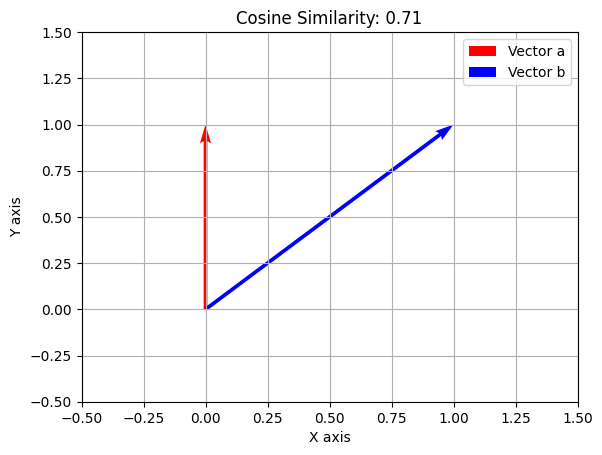

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 创建两个向量
a = np.array([0, 1])
b = np.array([1, 1])

# 计算两个向量的余弦相似度
cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# 绘制向量
plt.quiver(0, 0, a[0], a[1], angles='xy', scale_units='xy', scale=1, color='r')
plt.quiver(0, 0, b[0], b[1], angles='xy', scale_units='xy', scale=1, color='b')

# 设置图表属性
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.grid()
plt.title(f'Cosine Similarity: {cosine_similarity:.2f}')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# 添加图例
plt.legend(['Vector a', 'Vector b'])

# 显示图表
plt.show()

这幅图展示了二维空间中两个向量的方向。红色向量代表$\vec{a}$ ，蓝色向量代表 $\vec{b}$  。它们之间的夹角表示了两个向量的余弦相似度。余弦相似度是通过计算两个向量的点积并除以它们各自的范数（即长度）来得到的。在这个示例中，这两个向量的余弦相似度大约为 0.71，意味着它们在方向上有一定程度的相似性。这个值越接近 1，表示两个向量的方向越相似。

&emsp;&emsp;而相比之下，欧式距离的计算过程就要简单很多：

In [5]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# 计算欧氏距离
a = np.array([[0, 1]])
b = np.array([[1, 1]])
euclidean_dist = euclidean_distances(a, b)
euclidean_dist

array([[1.]])

- 余弦相似度和欧式距离在衡量文本相似度之间的差异

&emsp;&emsp;而接下来，我们就进一步测试余弦相似度和欧式距离在衡量文本相似度之间的差异。这里我们准本三段文本，分别是"我喜欢吃苹果", "苹果是我最喜欢吃的水果", "我喜欢用苹果手机"。很明显，从语义上来看，第一句和第二局表达的是相同含义，但表述方式不同，这两句句式有较大区别，而相比之下，第一句和第三局表意完全不同，但表述格式高度类似。在这种情况下，欧氏距离更容易收到句式的影响而发生误判，而余弦相似度则有更好的捕获类似表意语句的能力：

(array([[1.        , 0.70710678, 0.67082039],
        [0.70710678, 1.        , 0.47434165],
        [0.67082039, 0.47434165, 1.        ]]),
 array([[0.        , 2.        , 1.73205081],
        [2.        , 0.        , 2.64575131],
        [1.73205081, 2.64575131, 0.        ]]))

In [9]:
print(encoder.fit_transform([[word] for word in vocab]))

  (0, 4)	1.0
  (1, 0)	1.0
  (2, 3)	1.0
  (3, 8)	1.0
  (4, 5)	1.0
  (5, 6)	1.0
  (6, 9)	1.0
  (7, 2)	1.0
  (8, 7)	1.0
  (9, 1)	1.0


在这个例子中，我们首先对三个句子进行了 One-Hot 编码，然后分别计算了它们之间的余弦相似度和欧几里得距离。结果如下：       
- 余弦相似度计算结果：        
    句子1（"我喜欢吃苹果"）与句子2（"苹果是我最喜欢吃的水果"）的余弦相似度：0.7071       
    句子1（"我喜欢吃苹果"）与句子3（"我喜欢用苹果手机"）的余弦相似度：0.6708         
    句子2（"苹果是我最喜欢吃的水果"）与句子3（"我喜欢用苹果手机"）的余弦相似度：0.4743       
- 欧几里得距离        
    句子1（"我喜欢吃苹果"）与句子2（"苹果是我最喜欢吃的水果"）的欧几里得距离：2.0       
    句子1（"我喜欢吃苹果"）与句子3（"我喜欢用苹果手机"）的欧几里得距离：1.7              
    句子2（"苹果是我最喜欢吃的水果"）与句子3（"我喜欢用苹果手机"）的欧几里得距离：2.745

欧几里得距离考虑了向量的大小和维度差异，句子1和句子3之间的距离较小，表明在特征空间中它们相对更接近。而余弦相似度专注于向量的方向，忽略了它们的大小最终获得了更准确的判别效果。

> 欧式距离越小则代表越接近（相似），而余弦相似度则是越接近1代表越相似。

&emsp;&emsp;当然，除了One-Hot之外，早期文本编码方法中还有一个非常有名的方法：TF-IDF，逆向词频统计。不同于One-Hot是把每句话中每个单次出现的次数进行统计，TF-IDF会对高频词汇进行“逆向统计”，即会压缩其取值重要性。从本质上来说，该方法也是一种简单的文本编码方式，并未从根本上解决One-Hot编码带来的一系列问题。

&emsp;&emsp;尽管One-Hot编码的这些问题和局限性是显而易见的，但为了解决这些问题却花费了数十年的时间，这个过程不仅涉及了自然语言处理（NLP）领域的发展，还包括机器学习和深度学习技术的进步。早期有研究者开始使用基于统计的方法来尝试捕捉词之间的共现信息。然而，这些方法通常仍然无法完全捕获词义的复杂性。直到神经网络的出现才让捕获语义复杂关系变得可能，更具体来说，是大规模复杂神经网络Word2Vec的出现，才很好的解决了这个问题。

### 3.Word2Vec：Embedding技术的里程碑

&emsp;&emsp;Word2Vec是由 Google 的研究团队 Tomas Mikolov 在 2013 年推出，它的出现出现标志着自然语言处理（NLP）领域词嵌入技术的重要转折点。Word2Vec 引入了一种全新的思维方式来理解单词和文本。与传统的词表示方法如 One-Hot 编码相比，Word2Vec 能够将单词转化为多维空间中的向量，这些向量在捕捉词之间的语义和语法关系方面表现出色。

&emsp;&emsp;Word2Vec 的核心思想基于这样一个假设：词的含义可以通过其上下文来定义。它主要包含两种结构：Continuous Bag of Words（CBOW）和 Skip-Gram。CBOW 模型通过上下文预测当前词，而 Skip-Gram 则恰好相反，通过当前词预测其上下文。这两种方法都通过训练神经网络模型实现，有效利用大量未标记的文本数据。

&emsp;&emsp;Word2Vec 的推出对 NLP 领域产生了深远影响。首先，它大大改善了许多基于文本的应用，包括文本分类、情感分析和机器翻译。其次，Word2Vec 为后续的词嵌入技术，如 GloVe 和 FastText，乃至更先进的上下文相关嵌入模型（如 BERT 和 GPT）奠定了基础。这些模型在处理复杂的语言模式、捕捉词义的细微差别方面进一步提升了 Word2Vec 的概念。

&emsp;&emsp;Word2Vec 的诞生不仅是 NLP 领域的一个重要里程碑，更是整个机器学习和人工智能领域的一次重大革新。它的出现标志着从基于规则的语言处理向基于学习的语言处理的转变，为理解和处理人类语言开辟了新的可能性。

- Word2Vec训练过程

&emsp;&emsp;和现在的预训练大模型类似，Word2Vec 并不是通过有监督学习得到的，而是一种无监督学习技术。它不需要标记的训练数据（如分类标签或其他标注信息），而是直接从文本数据中学习单词的表示。下面是一个使用易懂语言描述的 Word2Vec 模型的训练过程：

1. **收集文本数据**：Word2Vec 的训练开始于收集大量的文本数据，这些数据可以是书籍、文章、网页等任何形式的文字。

2. **分词处理**：将这些文本数据分割成单词。例如，句子 "I like apples" 会被分割成 "I"、"like"、"apples"。

3. **选择模型**：Word2Vec 有两种模型可供选择，CBOW（连续词袋）和 Skip-Gram。
   - **CBOW**：这个模型试图根据一个词周围的上下文来预测这个词。比如，给定 "I ... apples"，它会尝试填充中间的词。
   - **Skip-Gram**：与 CBOW 相反，它根据一个词来预测其上下文。比如，给定 "like"，它会尝试预测 "I" 和 "apples"。

4. **创建神经网络**：Word2Vec 通过创建一个简单的神经网络来实现这一过程。这个网络不像传统的用于分类的神经网络那样复杂，它的目标是学习单词的嵌入。

5. **训练过程**：
   - 网络通过观察大量的上下文-单词配对来进行训练。例如，在 Skip-Gram 模型中，如果我们看到 "I like apples"，那么 ("like", "I") 和 ("like", "apples") 就是训练样本。
   - 通过这种方式，网络逐渐学习到单词的有效表示。这些表示捕捉了单词间的许多语义关系，例如同义词、反义词等。

6. **得到词向量**：训练完成后，每个单词都会被转化为一个向量（即一系列数字）。这些向量就是我们所说的词嵌入，它们包含了关于这些词的丰富信息。

总的来说，Word2Vec 是通过观察单词及其上下文的大量实例，无需任何人工标记的信息，来学习词汇的数学表示的一种方法。这些表示在处理自然语言时非常有用，因为它们捕捉了单词之间的复杂关系。

- Word2Vec极简使用过程

&emsp;&emsp;接下来，我们就来尝试调用WordsVec模型，并借此观察稠密词向量创建结果。这里我们假设令其创建一个100个维度的词向量（对于Word2Vec来说是可以规定词向量维度），仍然还是衡量"我喜欢吃苹果", "苹果是我最喜欢吃的水果", "我喜欢用苹果手机"三句话关联度，WordsVec模型的词向量化计算过程如下：

In [1]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import jieba

# 准备文本数据
sentences = ["我喜欢吃苹果", "苹果是我最喜欢吃的水果", "我喜欢用苹果手机"]

# 使用 jieba 进行中文分词
tokenized_sentences = [list(jieba.cut(sentence)) for sentence in sentences]

# 训练 Word2Vec 模型
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=2)

# 获取每个句子的平均向量表示
def get_sentence_vector(sentence, model):
    words = list(jieba.cut(sentence))
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return sum(word_vectors) / len(word_vectors)

sentence_vectors = [get_sentence_vector(sentence, model) for sentence in sentences]

# 计算句子间的余弦相似度
cosine_similarities = cosine_similarity(sentence_vectors)

cosine_similarities

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.376 seconds.
Prefix dict has been built successfully.


array([[0.9999999 , 0.7434623 , 0.6565231 ],
       [0.7434623 , 1.        , 0.45740122],
       [0.6565231 , 0.45740122, 1.        ]], dtype=float32)

能够发现，WordsVec模型能够非常好的计算得到1、2句话关联性较强的结论。而每句话的词向量如下所示：

In [2]:
sentence_vectors

[array([-0.00432601,  0.00406971,  0.00082073,  0.00285212,  0.00260904,
        -0.00250835,  0.00165858,  0.00615073, -0.0025268 , -0.00281055,
         0.00292883, -0.00209868,  0.00078521,  0.00207212,  0.00361077,
        -0.00070364,  0.00591563,  0.00327086, -0.00716529, -0.00208044,
         0.00106662, -0.00162748,  0.00522037, -0.00203441,  0.00282427,
        -0.00070741,  0.00217527,  0.00482545, -0.00344711,  0.00179091,
         0.00214926, -0.00413491, -0.0014018 , -0.00439473, -0.00079619,
         0.0020215 ,  0.00595606, -0.00062651,  0.00040572,  0.00335066,
        -0.00096744,  0.00122857, -0.00313262, -0.00018954,  0.00204034,
         0.00373947,  0.00064566,  0.00074721, -0.00025051,  0.00190524,
         0.00134328, -0.00189608, -0.00525017, -0.00329428, -0.00192758,
        -0.00053604,  0.00341957,  0.00121441, -0.00128411,  0.00227522,
        -0.00138613,  0.00118845,  0.00182446, -0.00309547, -0.00020932,
         0.00286489,  0.00342713,  0.00334012, -0.0

In [3]:
sentence_vectors[0]

array([-0.00432601,  0.00406971,  0.00082073,  0.00285212,  0.00260904,
       -0.00250835,  0.00165858,  0.00615073, -0.0025268 , -0.00281055,
        0.00292883, -0.00209868,  0.00078521,  0.00207212,  0.00361077,
       -0.00070364,  0.00591563,  0.00327086, -0.00716529, -0.00208044,
        0.00106662, -0.00162748,  0.00522037, -0.00203441,  0.00282427,
       -0.00070741,  0.00217527,  0.00482545, -0.00344711,  0.00179091,
        0.00214926, -0.00413491, -0.0014018 , -0.00439473, -0.00079619,
        0.0020215 ,  0.00595606, -0.00062651,  0.00040572,  0.00335066,
       -0.00096744,  0.00122857, -0.00313262, -0.00018954,  0.00204034,
        0.00373947,  0.00064566,  0.00074721, -0.00025051,  0.00190524,
        0.00134328, -0.00189608, -0.00525017, -0.00329428, -0.00192758,
       -0.00053604,  0.00341957,  0.00121441, -0.00128411,  0.00227522,
       -0.00138613,  0.00118845,  0.00182446, -0.00309547, -0.00020932,
        0.00286489,  0.00342713,  0.00334012, -0.00112963,  0.00

In [4]:
len(sentence_vectors[0])

100

&emsp;&emsp;**所以一个标准的Embedding过程是这样的**：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/image-20231027153920966.png" width='1000'></div>

&emsp;&emsp;首先，我们有`bovine buddies say`这样的文本输入，经过`Embedding model`这个模型被转化为由一串数字组成的向量。从上图能够清晰的看到，这个过程涉及到三个部分：
- **文本输入**：这是要转换为Embedding的初始数据，通常包括单词或句子，标识为`Text`；
- **Embedding模型**：这是一个预先训练好的模型，专门用于将文本转换为向量。其中，`word2vec`是典型代表；
- **向量输出**：通过Embedding模型处理后，文本将被转化为一个浮点数向量，这个向量具有固定的长度，如512或1024等，而其中的数值通常在[-1,1]范围内，标识为`Text as vector`；

&emsp;&emsp;Embedding过程可以被理解为：**使用训练好的 Embedding 模型将输入的单词、句子等文本信息转换为固定长度的浮点数向量列表，更深层次的，Embedding 技术实现了从“离散的文本序列”到“固定长度的浮点数向量”的转换任务**。这种输出的向量**在有效解决One-Hot编码存在的高维度和稀疏性问题的同时，也捕获了语义的相似度**。

&emsp;&emsp;能够发现，与 One-Hot 编码相比，Embedding的优势非常明显：
- **稠密向量**：与One-Hot编码不同，经过Embedding得到是稠密向量，它**为每个语义特征提供一个固定长度但是所有值都是不完全为0的向量。这些值通常是连续的浮点数**。

- **低维表示**：**Embedding 通常是低维的**，比如512、1024、2048维，远少于基于One-Hot的编码表示。

- **可以捕捉语义关系**：Embedding的关键优势在于，**相似的词或在语义上相关的词在 Embedding 空间中会被映射到接近的位置**。 比如“cat”和“kitten”的Embedding编码之间的相似度比“cat”和“car” 向量在Embeding空间中更加接近，因为它们在语义上具有相似性。

- **基于上下文的训练**：**大多数Embedding模型是通过大量的文本数据训练而来**，如Word2Vec、GloVe或FastText。这些模型通常会根据单词的上下文（即其在文本中的邻近词汇）来学习其向量表示。

- **转移学习**：**一旦训练好，Embedding可以被直接用于各种NLP任务，如文本分类、情感分析等**。这是因为这些Embedding向量捕捉了词汇的语义信息，这些信息在多个任务中都是有用的。

- **支持微调**：在某些任务中，**预训练的Embedding模型可以在特定的任务数据上进一步微调**，以更好地适应该特定任务。

&emsp;&emsp;可以看出，Embedding在多个层面上解决了One-Hot 编码的瓶颈，尽管方法不同，但其目标都是一致的，就是要将原始输入数据转化为数值向量，以便计算机能够处理。然而大家有没有考虑过：计算机是能够识别了，但是我们却看不懂了。不论是经过One-Hot Encoding， 还是Embedding的数据，这种编码形式的输出对我们来说都是不直观，且不容易理解的，这就引出了一个关键性的思考：我们是否能够从这些数值向量表示中恢复原始的自然语言或其他类型的数据呢？<br>

&emsp;&emsp;这个问题实质上涉及到编码的“可逆性”。

- **编码的可逆性**

&emsp;&emsp;首先，**One-Hot编码是“可逆”的**，也就是说，如果我们有一个分类变量，并且对它进行 One-Hot 编码后，我们可以直接从编码后的向量还原回原始的分类变量值。因为在 One-Hot 编码的向量中，只有一个元素的值为1，其余都是0，这个"1"的位置直接对应了原始分类变量的一个特定值。<br><br>
&emsp;&emsp;例如，考虑有这样一个词表：['红', '绿', '蓝']。从 One-Hot 编码的向量 [0, 1, 0]，我们可以直接推断原始的颜色是"绿"，因为在向量的第二个位置上有一个"1"。

&emsp;&emsp;而**对于Embedding来说，它是“不可逆”的**。因为 Embedding 通常是通过学习得到的，它捕获的是原始数据中复杂的语义信息，而不仅仅是原始值的编码。这就意味着从 Embedding 向量，我们不能直接还原回原始的分类变量值。<br><br>

&emsp;&emsp;如果更加通俗的来理解，我们可以将 One-Hot 编码想象为一个直接的、明确的标签系统。每个词汇都有一个唯一的标签，这使得还原非常简单。而 Embedding 更像是一个描述系统，它不仅包含了词汇的基本意义，还包括了词与其他词之间的复杂关系和上下文中的语义信息。在这里，每个词是通过一组特征来描述的，这使得还原变得复杂，因为相同的描述（或相似的Embedding）可以适用于多个不同的词汇。

&emsp;&emsp;正如在机器学习中，我们经常追求模型的“可解释性”，以便更好地理解模型的行为，同样地，对于数据的编码表示，了解其可逆性也是非常有价值的。

&emsp;&emsp;总的来说，**Embedding 的引入标志着从简单的高维、稀疏的表示方式，转向了一个更为紧凑、低维且富有语义的表示方法**。这种进步极大地推进了自然语言处理的发展，为深度学习模型提供了更强的能力去解析和生成人类的语言。而如果深入探究，与One-Hot 编码只是简单地将离散的文本序列转化为固定长度的高维稀疏矩阵不同，Embedding为我们提供了一种方法，可以将离散的文本序列转化为固定维度、连续的稠密矩阵，这一变化不仅使得数据的存储和处理更为高效，还使得模型能够捕捉到文本中更为深层次的语义信息。

- Word2Vec的静态Embedding模型特性

&emsp;&emsp;不过需要注意的是，Word2Vec本质上是一个一个静态嵌入模型，Word2Vec的核心特性是为每个单词生成一个固定的向量表示。这意味着无论一个词在文本中出现在何种上下文中，它的向量表示都保持不变。Word2Vec 模型通过学习文本数据中单词的使用模式，能够有效地捕捉和表示词汇之间的语义和语法关系。例如，语义上相似或相关的词在高维空间中的向量表示会彼此接近。

在实际使用过程中，Word2Vec优势与劣势分析如下：      

##### 优势：

1. **简单高效**：静态嵌入模型相对简单，易于训练和实施。它们不需要复杂的神经网络架构，因此在训练和应用时更加高效。

2. **良好的通用性**：这些模型能够生成通用的词向量，适用于各种不同的下游 NLP 任务，如文本分类、情感分析等。

3. **词义捕捉**：尽管是静态的，这些模型仍能有效地捕捉和表示词汇之间的语义和语法关系，特别是对于频繁出现的词汇。

4. **资源友好**：与复杂的上下文相关嵌入模型相比，静态模型在资源消耗方面更为节约，适用于资源受限的应用场景。

##### 劣势：

1. **缺乏上下文敏感性**：静态嵌入模型的主要劣势是无法捕捉词义的上下文变化。相同的词在不同的上下文中可能有不同的含义，而静态模型无法区分这些差异。

2. **对罕见词的处理**：静态模型在处理罕见词或特定领域的术语方面表现不佳，因为这些词在训练语料库中出现的频率可能较低。

3. **语义鲁棒性有限**：尽管能捕捉词义，静态模型在理解复杂的语言模式和精细的语义差别方面仍有局限。

总的来说，静态嵌入模型在简易性、效率和一般性方面表现出色，适合于广泛的基础 NLP 任务。然而，它们在处理复杂的上下文和细微的语义变化方面存在局限，这在一些高级的 NLP 应用中可能成为瓶颈。

> 除了Word2Vec模型外，常见的静态Embedding模型还有GloVe模型，该模型由斯坦福大学的Jeffrey Pennington、Richard Socher和Christopher Manning在2014年提出。

例如，对于以下四句话的关联性分析，Word2Vec就呈现出明显的性能不足问题："我买了一个苹果", "我买了一个苹果手机", "我买了一个橘子", "我买了一个手机"

In [37]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import jieba

# 准备文本数据
sentences = ["我买了一个苹果", "我买了一个苹果手机", "我买了一个橘子", "我买了一个手机"]

# 使用 jieba 进行中文分词
tokenized_sentences = [list(jieba.cut(sentence)) for sentence in sentences]

# 训练 Word2Vec 模型
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=2)

# 获取每个句子的平均向量表示
def get_sentence_vector(sentence, model):
    words = list(jieba.cut(sentence))
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return sum(word_vectors) / len(word_vectors)

sentence_vectors = [get_sentence_vector(sentence, model) for sentence in sentences]

# 计算句子间的余弦相似度
cosine_similarities = cosine_similarity(sentence_vectors)

cosine_similarities

array([[1.        , 0.9230337 , 0.79156816, 0.8119402 ],
       [0.9230337 , 1.        , 0.7204223 , 0.9078392 ],
       [0.79156816, 0.7204223 , 0.9999998 , 0.8069997 ],
       [0.8119402 , 0.9078392 , 0.8069997 , 0.9999999 ]], dtype=float32)

而相比之下，基于Transformer架构的新一代动态Embedding模型，则能够更好的根据实际上下文含义，而非机械的围绕每个单词进行固定编码，来获得更好的语义理解效果。

### 4.目前最通用的Embedding模型：动态Embedding模型

这些模型通常基于深度学习的架构，如 Transformer，利用大量的文本数据进行预训练。这种预训练-微调的范式极大地扩展了模型的适用性。在预训练阶段，模型学习大量通用的语言特征；在微调阶段，模型可以根据特定任务的需求进行调整，以适应不同的应用场景，从简单的文本分类到复杂的问答系统和文本生成任务。

动态嵌入模型的出现显著提升了机器对自然语言的理解能力。它们不仅能够更好地理解词和短语的含义，还能够处理长距离的依赖关系，这在传统的静态嵌入模型中是难以实现

在当今的自然语言处理（NLP）领域，动态嵌入模型已成为最通用和强大的词表示方法之一。这类模型，代表作如 BERT（Bidirectional Encoder Representations from Transformers）和 GPT（Generative Pre-trained Transformer），通过利用深度学习和复杂的神经网络结构，提供了一种能够捕捉词在不同语境中细微语义变化的方法。不同于静态嵌入模型，动态嵌入模型生成的词向量不是固定不变的，而是根据词在特定句子中的上下文动态调整，从而反映出词在不同语境中的具体含义。

动态嵌入模型的另一个显著优势在于其预训练和微调（Fine-tuning）的框架。通过在大量语料库上进行预训练，这些模型能够学习到丰富的语言知识和模式。随后，通过在特定任务的数据集上进行微调，模型能够将这些知识应用于各种具体的下游任务，如文本分类、问答系统和机器翻译等。

动态嵌入模型在理解复杂的语言结构、捕捉长期依赖关系以及处理多义词等方面表现出色。这些特性使得它们在处理高级语言理解任务时具有显著的优势。尽管这些模型的计算成本和资源需求相对较高，但它们在提高 N

In [40]:
text_tuples = ("我买了一个苹果", "我买了一个苹果手机", "我买了一个橘子", "我买了一个手机")
res = openai.Embedding.create(
  model="text-embedding-ada-002",
  input=text_tuples,
  encoding_format="float"
)

In [45]:
cosine_similarity([res.data[0].embedding, res.data[1].embedding, res.data[2].embedding, res.data[3].embedding])

array([[1.        , 0.96361361, 0.94059449, 0.93360997],
       [0.96361361, 1.        , 0.90843108, 0.97599684],
       [0.94059449, 0.90843108, 1.        , 0.90424674],
       [0.93360997, 0.97599684, 0.90424674, 1.        ]])

- Embedding模型在NLP领域的重大作用

&emsp;&emsp;而如今，Embedding技术作为自然语言处理的核心组件，广泛地应用于多个领域，以下为一些主要应用场景：
1. **搜索**：<br>
通过将查询字符串和文档都转化为Embedding，我们可以计算其之间的相似度（例如余弦相似度），返回与查询内容相关的结果，并按照相关性进行排序。这样，可以确保返回的搜索结果与用户查询更语义相关;

2. **聚类**：<br>
将文本转化为Embedding后，可以使用传统的聚类算法（如K-means）在低维空间中进行操作。由于Embedding捕获了文本的语义，所得到的聚类会更具实际意义;

3. **推荐**：<br>
Embedding可以基于用户的兴趣和项目的内容。通过计算用户Embedding和项目Embedding之间的相似度，可以推荐最相关的项目;

4. **异常检测**<br>
在大量正常的文本数据的Embedding空间中，正常的数据点可能会聚集在一起，而异常的数据点可能会偏离这些集群。因此，Embedding可以帮助识别这些偏离正常模式的异常值;

5. **多样性测量**：<br>
在一个文本集合中，可以计算文本Embedding之间的距离或相似度，从而得到整个集合的相似度分布。这可以帮助我们了解集合中内容的多样性;

6. **分类**：<br>
根据其内容，文本Embedding可以与现有的机器学习或深度学习分类器结合使用。由于Embedding捕获了文本的语义信息，分类器能够更准确地对文本进行分类;

&emsp;&emsp;而在大模型技术时间应用领域，Embedding的核心作用则是进行更效率或者更高层次的文本匹配，来辅助大模型进行更高效率、更有针对性的文本输入。

&emsp;&emsp;至此，我们已经为大家呈现了一个关于Embedding模型的全景式概览。通过这个简要的介绍帮助大家对Embedding的多样性和深度有一个初步的认识。但这部分内容不会作为本节的重点，在后面的课程中我们会安排单独的课时，为大家细致地拆解这些先进的开源Embedding技术，深入讲解它们的理论基础和实际应用方式。

&emsp;&emsp;**本节内容将深入探讨OpenAI的Embedding模型，其作为一种动态Embedding，在多项性能评估中表现出色，也是大模型技术人必须掌握的至关重要的Embedding模型。**

# 二、OpenAI Embedding模型详解

&emsp;&emsp;OpenAI拥有非常丰富的大模型生态，其API是由一系列涵盖对话、图像、审查等具有不同能力和价格选项的多样化模型提供支持，正如我们在之前的课程中使用的`gpt-3.5-turbo`、`gpt-4`等，它们都有自己特有的EndPoint，**每一个EndPoint对应着不同的服务模型，这就意味着根据所选的EndPoint，背后为我们服务的模型也会有所不同**。

> 如何理解"EndPoint"？<br>
在计算机网络和Web开发中，EndPoint通常指的是互联网上一个服务的终端或访问点。简单地说，当你希望与一个在线服务进行交互时，你会发送一个请求到这个服务的一个指定的EndPoint。在OpenAI的上下文中，不同的EndPoint代表的是不同的模型或服务，所以你可以根据需求选择合适的EndPoint来访问特定的模型功能。

<div align=center><img src="https://snowball97.oss-cn-beijing.aliyuncs.com/images/202311111649037.png"></div>

> OpenAI Models Overview：https://platform.openai.com/docs/models/overview

&emsp;&emsp;简而言之，**若我们想使用OpenAI的Embedding模型获取文本的Embeding向量化表示，只要学会其API调用的方法即可**。也就是说，我们要明确OpenAI Embedding模型的EndPoint是如何设定的。

## 2.1 OpenAI Embedding模型：两代模型的迭代升级

&emsp;&emsp;OpenAI的大模型一直在快速迭代，每一个新版本都相较于前一代在能力和功能上有显著的增强和完善。截止目前，GPT模型已经发展到第四代，刚刚发布的GPT-4 Turbo相较于早期版本展现出了更为出色的性能，同样地，其**Embedding模型也经历了两代的升级与完善**。如下图所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/image-20231101160420727.png"></div>

&emsp;&emsp;**OpenAI 提供了一个第二代 Embedding 模型（在模型 ID 中标记为 -002）和 16 个第一代模型（在模型 ID 中标记为 -001）**。

<div align=center><img src="https://snowball97.oss-cn-beijing.aliyuncs.com/images/202311111732909.png"></div>

> OpenAI Embedding Docs：https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

&emsp;&emsp;接下来，我们先深入探讨OpenAI的Embedding模型中每一代模型的能力，并评估它们在实际应用中的表现。

### 2.1.1 功能多样：OpenAI首代16个细分的Embedding模型

&emsp;&emsp;OpenAI的第一代Embedding模型**共发布了16个，均以`-001`标识**。从功能上，由**四种不同的基座模型构成**，如下所示：

| 基座模型类别 |功能| 输出的Embedding长度 |
|:------|:---------|:-------------------|
| Ada  | 能够执行非常简单的任务，通常是GPT-3系列中速度最快且成本最低的模型| 1024              |
| Babbage |能够执行简单的任务，非常快速且成本更低| 2048            |
| Curie | 非常强大，比davinci更快速和成本更低|4096             |
| Davinci |最强大的GPT-3模型。能够执行其他模型能够执行的任何任务，并且通常具有更高的质量| 12288          |


&emsp;&emsp;进一步地，**根据不同的搜索任务，可以分为3类**：

| 搜索任务类型 | 描述 |
|:--------------|:------|
| 相似性嵌入 (Similarity embeddings) | 专注于捕获文本片段之间的语义相似性 |
| 文本搜索嵌入 (Text search embeddings) | 有助于衡量哪些长文档与短搜索查询最相关 |
| 代码搜索嵌入 (Code search embeddings) | 擅长自然语言搜索查询和检索的代码片段 |

&emsp;&emsp;结合以上基座模型和搜索任务分类，经过**细分后的16个模型都有其独特的应用场景和优势**，同时**模型命名遵循“用途-基座模型-特定功能-版本号”的规范**，如"text-similarity-ada-001"表示用于文本相似性分析的Ada基座模型的第一代模型，具体如下：

- **相似性模型**

&emsp;&emsp;相似性模型**擅长捕捉文本之间的语义相似性**，通过计算文本向量之间的相似度来识别最接近的文本。简单来说，每段文本都被转换成一个Embedding向量，然后，模型通过计算这些向量之间的距离或相似度来判断文本之间的相似程度。两个向量距离越近或相似度越高，意味着它们代表的文本在语义上越接近。

<table data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
    <thead data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
        <tr data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
            <th data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Use cases
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <font class="notranslate" data-immersive-translate-translation-element-mark="1">
                        &nbsp;
                    </font>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-inline-wrapper-theme-dashed immersive-translate-target-translation-inline-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            使用案例
                        </font>
                    </font>
                </font>
            </th>
            <th data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Available models
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <font class="notranslate" data-immersive-translate-translation-element-mark="1">
                        &nbsp;
                    </font>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-inline-wrapper-theme-dashed immersive-translate-target-translation-inline-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            可用型号
                        </font>
                    </font>
                </font>
            </th>
        </tr>
        <tr data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
            <td data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Clustering, regression, anomaly detection, visualization
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <br>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-block-wrapper-theme-dashed immersive-translate-target-translation-block-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            聚类分析、回归、异常检测、可视化
                        </font>
                    </font>
                </font>
            </td>
            <td data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-similarity-ada-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-similarity-babbage-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-similarity-curie-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-similarity-davinci-001
                </code>
            </td>
        </tr>
        
        
    
</table>


- **文本搜索模型**

&emsp;&emsp;文本搜索模型可以衡量长文档与短搜索查询之间的相关性，通过将文本（无论是搜索查询还是文档）转换为向量，然后比较这些向量之间的相似性，来确定哪些文档与特定搜索查询最相关。

<table data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
    <thead data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
        <tr data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
            <th data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Use cases
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <font class="notranslate" data-immersive-translate-translation-element-mark="1">
                        &nbsp;
                    </font>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-inline-wrapper-theme-dashed immersive-translate-target-translation-inline-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            使用场景
                        </font>
                    </font>
                </font>
            </th>
            <th data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Available models
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <font class="notranslate" data-immersive-translate-translation-element-mark="1">
                        &nbsp;
                    </font>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-inline-wrapper-theme-dashed immersive-translate-target-translation-inline-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            可用模型
                        </font>
                    </font>
                </font>
            </th>
        </tr>
        <tr data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
            <td data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Search, context relevance, information retrieval
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <br>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-block-wrapper-theme-dashed immersive-translate-target-translation-block-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            搜索、上下文相关性、信息检索
                        </font>
                    </font>
                </font>
            </td>
            <td data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-search-ada-doc-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-search-ada-query-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-search-babbage-doc-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-search-babbage-query-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-search-curie-doc-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-search-curie-query-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-search-davinci-doc-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    text-search-davinci-query-001
                </code>
            </td>
        </tr>
</table>


- **代码搜索模型**

&emsp;&emsp;与搜索模型一样，**帮助用户在大量的代码库中找到特定的代码片段**。这些模型可以理解自然语言查询（如搜索指令或问题），并将其与存储的代码片段进行比较，从而找到与查询最相关的代码。

<table data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
    <thead data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
        <tr data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
            <th data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Use cases
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <font class="notranslate" data-immersive-translate-translation-element-mark="1">
                        &nbsp;
                    </font>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-inline-wrapper-theme-dashed immersive-translate-target-translation-inline-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            使用场景
                        </font>
                    </font>
                </font>
            </th>
            <th data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Available models
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <font class="notranslate" data-immersive-translate-translation-element-mark="1">
                        &nbsp;
                    </font>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-inline-wrapper-theme-dashed immersive-translate-target-translation-inline-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            可用模型
                        </font>
                    </font>
                </font>
            </th>
        </tr>
        <tr data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
            <td data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                Code search and relevance
                <font class="notranslate immersive-translate-target-wrapper" lang="zh-CN"
                data-immersive-translate-translation-element-mark="1">
                    <br>
                    <font class="notranslate immersive-translate-target-translation-theme-dashed immersive-translate-target-translation-block-wrapper-theme-dashed immersive-translate-target-translation-block-wrapper"
                    data-immersive-translate-translation-element-mark="1">
                        <font class="notranslate immersive-translate-target-inner immersive-translate-target-translation-theme-dashed-inner"
                        data-immersive-translate-translation-element-mark="1">
                            代码搜索和相关性
                        </font>
                    </font>
                </font>
            </td>
            <td data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    code-search-ada-code-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    code-search-ada-text-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    code-search-babbage-code-001
                </code>
                <br data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                <code data-immersive-translate-effect="1" data-immersive_translate_walked="3911974b-89f1-492c-b246-2cb067ea9caf">
                    code-search-babbage-text-001
                </code>
            </td>
        </tr>
    </tbody>
</table>


&emsp;&emsp;**Ada、Babbage、Curie、Davinci这四大基座模型支持的最大输入长度都是2046个token**，在对这16个模型的实际使用效果评估中，在性能方面，Davinci最强，但相应地，其运行速度较慢且成本更高，与此相对，**Ada虽然能力稍逊，但提供了更快的响应速度和更经济的价格**。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/image-20231101162623480.png"></div>

&emsp;&emsp;OpenAI的第一代Embedding模型虽然在发布时展现了强大的能力，但也存在一些明显的局限性。16个模型的多样性可能导致用户在选择上感到困惑，不确定哪个最适合他们的需求。此外，模型按照不同功能进行细分，如文本搜索、文本相似性和代码搜索，也增加了使用的复杂性。

&emsp;&emsp;**随着更为强大的第二代Embedding模型的发布，我们不推荐使用这些第一代Embedding模型**。

### 2.1.2 单一高效：OpenAI第二代综合Embedding模型

&emsp;&emsp;**OpenAI发布的第二代Embedding仅有一个，即`text-embedding-ada-002`，** 相较于第一代的16个Embedding模型，它进行了如下改进：
- **模型统一**： 取代了文本搜索、文本相似性和代码搜索的三种独立模型；
- **更长的上下文输入**： 上下文长度增加了四倍，从 2048 增加到 8192，可以更方便地处理长文档；
- **更小的输出维度**： 新的Embedding只有 1536 个维度，是 davinci-001 Embedding的八分之一，这使得新的Embedding在使用矢量数据库时更具成本效益；
- **更好的性能**： 在大多数任务上的性能都优于之前功能最强大的模型 Davinci 模型；
- **更低的成本**： 价格降低了99.8%；

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/image-20231101165307324.png"></div>

&emsp;&emsp;在不同任务上，第二代新模型 `text-embedding-ada-002` 相较第一代的16个模型，都有比较明显的提升，**在文本搜索、代码搜索和句子相似性任务上优于所有第一代的 Embedding 模型，并在文本分类上获得可比的性能**。其官方评测如下：

- **文本搜索**

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/Snipaste_2023-10-31_15-49-43.jpg"></div>

- **代码搜索**

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/Snipaste_2023-10-31_15-50-05.jpg"></div>

- **句子相似度**

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/Snipaste_2023-10-31_15-50-29.jpg"></div>

- **文本分类**

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/Snipaste_2023-10-31_15-50-40.jpg"></div>

> OpenAI imporved-embedding Blog：https://openai.com/blog/new-and-improved-embedding-model

&emsp;&emsp;需要说明的是，**第二代新模型 `text-embedding-ada-002` 是目前应用最广泛的的 Embedding 模型**，同时我们后面课程的相关内容，也将统一使用 `text-embedding-ada-002`模型做文本的Embedding。

## 2.2 OpenAI 的 Embedding 第二代模型：`text-embedding-ada-002`的调用方法及参数解析

&emsp;&emsp;OpenAI 的 Embedding 模型的参数配置和使用方法，在OpenAI官方文档中都有详尽的说明和示例。接下来，我们尝试在本地调用`text-embedding-ada-002`模型。

> OpenAI Embeddings：https://platform.openai.com/docs/api-reference/embeddings

### 2.2.1 text-embedding-ada-002模型的本地调用测试

&emsp;&emsp;在OpenAI的官方文档中，我们可以找到关于 text-embedding-ada-002 模型调用示例，如下图所示： 

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/image-20231101184302178.png"></div>

&emsp;&emsp;官方提供了**三种调用`text-embedding-ada-002`模型的方式，分别是curl、python和node.js**，我们这里选择使用Python环境来进行调用测试，代码如下：

In [55]:
res = openai.Embedding.create(
  model="text-embedding-ada-002",
  input="The food was delicious and the waiter...",
  encoding_format="float"
)

In [56]:
res

<OpenAIObject list at 0x15d69450400> JSON: {
  "object": "list",
  "data": [
    {
      "object": "embedding",
      "index": 0,
      "embedding": [
        0.002253932,
        -0.009333183,
        0.01574578,
        -0.007790351,
        -0.004711035,
        0.014844206,
        -0.009739526,
        -0.03822161,
        -0.0069014765,
        -0.028723348,
        0.02523134,
        0.01814574,
        -0.003650735,
        -0.025498003,
        0.0004960238,
        -0.016317198,
        0.028418591,
        0.0053268983,
        0.009618893,
        -0.01644418,
        -0.015339436,
        0.0042634234,
        0.0070284586,
        -0.007079251,
        -0.003920572,
        0.01850129,
        0.008704622,
        -0.02275519,
        0.011447435,
        0.02382184,
        0.015529909,
        -0.0035269274,
        -0.034920074,
        -0.00414914,
        -0.026107516,
        -0.021523464,
        -0.0057459394,
        0.011758541,
        0.008317326,
        0.0

&emsp;&emsp;如果能正常接收到输出，说明调用 Embedding 模型成功。

&emsp;&emsp;通过这样简单的几行代码，就已经完成了`text-embedding-ada-002` 的一次调用流程，还是非常符合OpenAI简单、易用的一贯风格。

### 2.2.2 text-embedding-ada-002模型的调用流程和参数介绍

&emsp;&emsp;如上一小节中的示例所示，在单次调用中，包括**发送请求与接收请求**两个过程。

&emsp;&emsp;text-embedding-ada-002模型需要**通过 `openai.Embedding.create` 方法发起请求**，在这个过程中，涉及三个关键参数： `model`、`input`、`encoding_format` ，具体来说：

|参数|是否必要参数|含义|备注|
|:-------|:-------|:-------|:-------|
|`model`|是|模型名称|Embedding模型的 ID，包含第一代的16个模型和第二代的1个模型|
|`input`|是|输入文本|输入需要进行Embedding的文本|
|`encoding_format`|否|编码格式(float or base64)|`float`用于精确地表示小数和实数<br>`base64`是一种用64个字符来表示任意二进制数据的方法

- **`model`参数决定调用哪个OpenAI Embedding 模型**

&emsp;&emsp;首先，`model` 参数指定了想调用的模型ID。正如我们在`2.1 OpenAI Embedding模型：两代模型的迭代升级`中所介绍的，包括16个第一代Embedding模型和1个第二代Embedding模型在内，可以通过更改为相应的模型ID来选择不同的模型，**简而言之，`model` 参数决定了将使用哪个特定的Embedding模型来生成文本Embedding。**

| Embedding模型版本 | 模型ID |
|------|----------------------------------------|
| 第一代 | text-similarity-ada-001<br>text-similarity-babbage-001<br>text-similarity-curie-001<br>text-similarity-davinci-001<br>text-search-ada-query-001<br>text-search-ada-doc-001<br>text-search-babbage-query-001<br>text-search-babbage-doc-001<br>text-search-curie-query-001<br>text-search-curie-doc-001<br>text-search-davinci-query-001<br>text-search-davinci-doc-001<br>code-search-ada-code-001<br>code-search-ada-text-001<br>code-search-babbage-code-001<br>code-search-babbage-text-001 |
| 第二代 | text-embedding-ada-002 |


In [41]:
res = openai.Embedding.create(
  # 调用第二代Embedding
  model="text-embedding-ada-002",
  input="The food was delicious and the waiter...",
  encoding_format="float"
)
res

<OpenAIObject list at 0x1e7ec014400> JSON: {
  "object": "list",
  "data": [
    {
      "object": "embedding",
      "index": 0,
      "embedding": [
        0.002253932,
        -0.009333183,
        0.01574578,
        -0.007790351,
        -0.004711035,
        0.014844206,
        -0.009739526,
        -0.03822161,
        -0.0069014765,
        -0.028723348,
        0.02523134,
        0.01814574,
        -0.003650735,
        -0.025498003,
        0.0004960238,
        -0.016317198,
        0.028418591,
        0.0053268983,
        0.009618893,
        -0.01644418,
        -0.015339436,
        0.0042634234,
        0.0070284586,
        -0.007079251,
        -0.003920572,
        0.01850129,
        0.008704622,
        -0.02275519,
        0.011447435,
        0.02382184,
        0.015529909,
        -0.0035269274,
        -0.034920074,
        -0.00414914,
        -0.026107516,
        -0.021523464,
        -0.0057459394,
        0.011758541,
        0.008317326,
        0.0

In [42]:
res_1 = openai.Embedding.create(
  # 调用第一代Embedding
  model="text-search-ada-doc-001",
  input="The food was delicious and the waiter...",
  encoding_format="float"
)
res_1

<OpenAIObject list at 0x1e7e45a8f40> JSON: {
  "warning": "This model version is deprecated and a newer version 'text-embedding-ada-002' is available. Migrate before January 4, 2024 to avoid disruption of service. Learn more https://platform.openai.com/docs/deprecations",
  "object": "list",
  "data": [
    {
      "object": "embedding",
      "index": 0,
      "embedding": [
        0.01812645,
        0.021205688,
        0.010695222,
        0.029971253,
        -0.028390579,
        0.0097714495,
        0.024818663,
        -0.007610851,
        0.042288207,
        0.017141094,
        -0.033255775,
        0.0046855747,
        0.023258515,
        0.040645946,
        -0.010402693,
        -0.070247695,
        -0.015817022,
        -0.0060507036,
        0.0028431634,
        0.029006425,
        0.029971253,
        -0.0626933,
        0.06006568,
        -0.008093265,
        0.024202814,
        0.03779252,
        0.014800873,
        0.019850824,
        -0.028164767,
   

&emsp;&emsp;如果能正常接收到输出，说明调用的 Embedding 模型成功。

- **`input`参数定义了要处理的文本内容，不同类型的输入将影响返回结果的格式**

&emsp;&emsp;其次，对于`input`参数来说，**输入的就是需要进行Embedding的文本，但需要注意的是：输入不得超过模型的最大输入限制（ `text-embedding-ada-002`模型为8192 个），并且不能为空字符串**。如果传入的文本为字符串形式：

In [43]:
res = openai.Embedding.create(
  # 调用第二代Embedding
  model="text-embedding-ada-002",
  input="我是字符串格式",
  encoding_format="float"
)
res

<OpenAIObject list at 0x1e7ec0aaf70> JSON: {
  "object": "list",
  "data": [
    {
      "object": "embedding",
      "index": 0,
      "embedding": [
        -0.024826873,
        -0.0010025145,
        0.0028070405,
        -0.006575785,
        -0.025181744,
        0.008538229,
        -0.012690237,
        -0.0043791253,
        -0.01821205,
        -0.017757814,
        0.0094538005,
        0.03131394,
        -0.00508887,
        0.0071116425,
        -0.011859835,
        0.0070761554,
        0.005127906,
        0.0108449,
        0.014131019,
        0.017516501,
        0.005731189,
        0.016423494,
        -0.010766828,
        -0.0146633275,
        -0.017715229,
        0.022229206,
        -0.0013964229,
        0.0032399849,
        0.0021434291,
        -0.021192979,
        0.020852301,
        -0.0072287507,
        -0.026146997,
        -0.02997962,
        0.008609205,
        -0.0030235127,
        -0.012945744,
        -0.009886744,
        0.0125837745,
  

&emsp;&emsp;当发送请求成功后，**返回的请求结果 `res` 是一个JSON格式的数据，主要包含四个部分：object（数据类型），data（包含Embedding向量的详细信息），model（所用模型的ID），以及usage（token使用情况）。**格式如下：

```json
{
  "object": "list",             // 请求结果的data类型
  "data": [                     // 结果数据 list[json]
    {
      "object": "embedding",    // 结果种类
      "embedding": [            // `openai.Embedding.create` embedding 结果 长度为1536的列表
        0.0023064255,
        -0.009327292,
        // .... (1536 floats total for ada-002)
        -0.0028842222,
      ],
      "index": 0                // 发送字符串只有一个embedding结果都是0，  发送数组时表示数组对应的index
    }
  ],
  "model": "text-embedding-ada-002",  // embedding 使用的模型
  "usage": {                    // token 使用情况   单向计价
    "prompt_tokens": 8,         // 发送 token数量
    "total_tokens": 8           // 总共 token数量
  }
}
```

&emsp;&emsp;**除了传入字符串格式的文本，还可以输入文本数组**，如下：

In [67]:
text_tuples = ("这里是大模型实战课程!", "The food was delicious and the waiter...")
openai.Embedding.create(
  model="text-embedding-ada-002",
  input=text_tuples,
  encoding_format="float"
)

<OpenAIObject list at 0x15d6930a4f0> JSON: {
  "object": "list",
  "data": [
    {
      "object": "embedding",
      "index": 0,
      "embedding": [
        -0.021023555,
        -0.006319699,
        -0.01257291,
        -0.00072222756,
        -0.027472904,
        0.0074466732,
        -0.014919941,
        0.017260324,
        -0.0039527207,
        -0.047951255,
        -0.0010372152,
        0.036435507,
        -0.01190138,
        -0.005594978,
        0.0037466073,
        -0.015531632,
        0.012931946,
        -0.009740515,
        0.009388127,
        -0.010737836,
        0.0136566665,
        0.031249432,
        0.00479712,
        -0.022925114,
        -0.011794998,
        0.014361441,
        0.02120972,
        -0.018497003,
        0.0029421009,
        -0.008065013,
        0.021249613,
        -0.0068549286,
        -0.0023736272,
        -0.04013225,
        0.015212489,
        0.022832032,
        0.022699056,
        0.013669964,
        0.006868226,
    

&emsp;&emsp;可以看到，**不同的输入格式，会导致 Embedding 模型返回的数据结构也发生变化**，对于上述文本数组类型的输入，其返回结果的结构如下：

```json
<OpenAIObject list at 0x15d6930a4f0> JSON: {
  "object": "list",
  "data": [
    {
      "object": "embedding",
      "index": 0,
      "embedding": [-0.021023555, ..., -0.027685666]  // 长度为1536的列表
    },
    {
      "object": "embedding",
      "index": 1,
      "embedding": [0.002253932, ..., -0.0027967806]  // 长度为1536的列表
    }
  ],
  "model": "text-embedding-ada-002-v2",
  "usage": {
    "prompt_tokens": 21,
    "total_tokens": 21
  }
}
```

&emsp;&emsp;能够发现，当输入为文本数组而非单个字符串时，OpenAI的Embedding模型返回的结果结构会有所不同。我们**输入了一个包含两个文本项的数组（text_tuples）。因此，返回的data部分包含两个独立的Embedding向量对象**。每个对象都有以下信息：

    1.object: 类型标记为“embedding”。
    2.index: 表示该嵌入向量在输入数组中的位置索引。
    3.embedding: 对应文本的嵌入向量，长度为1536

- **`encoding_format`参数用于指定输入数据的编码格式。这是一个非必选参数，其可选值包括 base64 和 float，其中 float 是默认值。**

&emsp;&emsp;之前的示例我们使用的就是encoding_format="float"参数，现在，我们直接使用 encoding_format="base64" 来进行测试。

In [57]:
res_base64 = openai.Embedding.create(
  model="text-embedding-ada-002",
  input="The food was delicious and the waiter...",
  encoding_format="base64"
)
res_base64

<OpenAIObject list at 0x15d6940d400> JSON: {
  "object": "list",
  "data": [
    {
      "object": "embedding",
      "index": 0,
      "embedding": "tLYTOzXqGLxL/YA8M0b/uwdfmrsdNXM8iJIfvEOOHL3IJeK7Ok3rvPWxzjxgppQ8K0FvuzDh0LyYBwI6pauFvBvO6DxDja47kJgdPPK1hrxCUnu8MLSLO/xO5jsQ+ee7JHiAuwSQlzzVnQ48GGm6vAaOOzwFJsM8KXF+PAYkZ7taCA+9gvWHu27f1bz6UbC8b0i8u+WmQDxlRQg8zDCGO2kTnTzKjGy80GYTPLJ8zjsiPju9oAySPOtFtLuZm1G660W0vHDdebuD86s8WgiPvGA8QLyIKbm8UZuGPB/ZjDyrSQu8hPHPOmVyzTy6gsy8pAb+O47Hvju9urW8vrlHO2KjyruE8c+8TswDvEC/mTp/JgU4sH+YO8NZqTzMXF0887SYO76Mgrz8ioc8JXcSvMvz9rsjPF88gbnmuxYCsDvEwSE86t07vS56RjvXmsQ8i/i7PFMu6Dvwe8G8b7EiPEFU17vEKgi9SMQpu86Wojxo2Ok6M4OOOpL+ubxCJqQ7CvJ7PHGCAT3odrG7C5eDvEX1prtvsaI8ZkQavH9S3Lu5sP+8jckavKg9ebxEIuy8g/OrPPDllbw9hkK7xyZQPLF+qjsDvkq9+lEwvdNjybnTzK88OLqJvDZ/1jumqSm9mTF9OrJPCT15tFY8QL4rvLmw/7k98JY81DSoODZ/VrzUy0E8HgfAO10D6Ttz6Qs8PfCWPClEOboAWZy8P1azPKKf87xXOYy7Qb29Oocqp7sEVHY8onKuPMUpmryXNTU8op/zu8CJuDyQmJ08+X51PKoNarstEs47fevRPFdl47wyGxY9oAySuwpbYjyi3AI8wIm4u98JKTztrL67km

> 什么是 `base64`？<br>
base64是一种用64个字符来表示任意**二进制**数据的方法。它常用于在文本中传输二进制数据，例如在邮件中发送附件或在HTML中嵌入图像。<br>
特点: base64编码后的文本会比原始二进制数据稍微长一些（大约增加1/3），但可以确保数据在传输过程中不会受到损坏，因为它只使用ASCII字符。<br>

&emsp;&emsp;**float 适用于常规文本输入，而 base64 通常用于处理非文本（如图像）的二进制数据。选择不同的 encoding_format 影响的是数据的编码和传输方式，而非Embedding向量的实际内容**。**建议使用默认的 encoding_format="float"即可**，它简单且高效，适合处理标准文本输入，满足大部分文本Embedding的需求。

&emsp;&emsp;总体而言，OpenAI 提供的 Embedding 模型API 对用户是非常友好的，无需繁琐的模型参数配置，且回传结果结构清晰直观。实践过我们前面课程中Chat类模型API的同学，理解和应用Embedding 模型应该是比较容易的。

&emsp;&emsp;**但需要说明的是，使用OpenAI的Embedding模型同样会产生相应的费用，为了更好地管理成本，我们需要了解如果估算在使用Embedding模型时所需承担的费用。**

## 2.3 text-embedding-ada-002模型的调用费用估算

&emsp;&emsp;同 Chat类的 gpt3.5 和 gpt 4 系列模型一样，**OpenAI的Embedding模型API也是按照输入文本的Token数量来计费**。以下是官方对Embedding模型计费方式的说明：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/Snipaste_2023-10-31_16-43-08.jpg"></div>

> OpenAI Pricing：https://openai.com/pricing

> `ada v2` 和 `text-embedding-ada-002` 实际上指的是同一个模型。在OpenAI的命名规范中，ada系列代表了一种特定的模型架构和训练方式，而v2通常表示这是第二版或者经过改进的版本。在这种情况下，ada v2是模型的简称，而text-embedding-ada-002则是该模型在特定应用场景下的完整名称，这种命名差异主要是为了区分模型的不同版本和应用场景。

&emsp;&emsp;从官方信息上可以明确看到**，`text-embedding-ada-002`模型的计价方式是：每1000个Tokens的费用为0.0001美元**。也就是，1美元可以处理$1000 \times 10000=10,000,000$ 个Tokens。**在 Embedding模型API的调用过程中，费用是基于单向计算的**，这意味着我们仅为发送的字符串所对应的Token数量付费，而接收的返回结果则不收取额外费用。

### 2.3.1 如何计算一个文本有多少Tokens

&emsp;&emsp;在之前的课程中我们讨论过Token的概念。**Token可以被视为文本的基本单位，它类似于单词或标点符号，如果将一个文本划分为多个子部分，每个子部分即一个Token**。一个最简单的Token切分方式是按空格和标点符号将文本分割成单词和符号，例如：

- 在英文中，句子“Hello, I am learning LLM!”可以被分割成："Hello"，","，"I"，"am"，"learning"，"LLM"，"!"。每个单词和标点符号都被视为独立的Token；

- 在中文中，句子“我正在学习大模型课程”将被分割为"我"，"正"，"在"，"学"，"习"，"大"，"模"，"型"，"课"，"程"。每个汉字单独成为一个Token，因为中文文本通常没有像英文那样的空格分隔符；

&emsp;&emsp;这种基于空格和标点符号的简单Token切分方法很直观，但它并未考虑文本的语义和上下文。因此**在实际应用时，通常要依赖更高级的编码器，编码器会遵循一系列复杂的规则将文本地分割成Tokens**。通过高级的文本切分方法，使后续的处理过程能更深入地理解和分析文本的含义和内容。**需要注意的是：不同的编码器会根据它们各自定义的规则来切分文本，这意味着对于相同的文本，当使用不同的编码器时，得到的Tokens可能会有所不同。这是因为每个编码器可能采用不同的方法来理解和解析文本，从而影响最终的Token切分结果。**

&emsp;&emsp;**当我们利用`text-embedding-ada-002`模型进行文本Embedding时，它所使用的`cl100k_base`编码器将依照其特定的规则来切分文本**。所以当我们向模型输入文本时，编码器会按照这些预设规则先对我们输入的文本进行Token切分。

<div align=center><img src="https://snowball97.oss-cn-beijing.aliyuncs.com/images/202311112355091.png"></div>

&emsp;&emsp;当我们**每次完成`text-embedding-ada-002` API的一次调用后，返回的数据中就会包含该次调用所消耗的Tokens信息**，我们测试一下：

In [45]:
res = openai.Embedding.create(
  # 调用第二代Embedding
  model="text-embedding-ada-002",
  input="我想测试一下这段文本占用了多少Tokens",
  encoding_format="float"
)
res["usage"]

<OpenAIObject at 0x1e7ec1564d0> JSON: {
  "prompt_tokens": 17,
  "total_tokens": 17
}

&emsp;&emsp;可以看到，输入的文本“我想测试一下这段文本占用了多少Tokens”按照`cl100k_base`编码器的切分规则被分解成了17个Tokens。

> 在使用text-embedding-ada-002模型时，其预设的编码器cl100k_base是不允许我们更改的。

### 2.3.2 如何在调用前计算传入文本的Tokens

&emsp;&emsp;虽然成功调用`text-embedding-ada-002` API后，在其返回的数据结果中会指明消耗了多少Tokens，但在处理大量数据时，直接调用可能会导致高额费用。所以很多时候，**我们需要在实际发生调用之前，明确此次将耗费的Tokens**。**OpenAI发布的Python库tiktoken能够在不实际发起API调用的情况下估算字符串的Token数量**。以此帮助我们预先评估使用成本。

&emsp;&emsp;计算过程如下：

In [4]:
# 安装时取消注释并执行
# ! pip install tiktoken

&emsp;&emsp;安装好tiktoken库后，我们可以使用这个第三方库计算输入文本的Token数量，具体来说：我们可以定义一个工具函数，接收输入文本和编码器的名称，使用该编码器对文本进行切分，最后计算并返回Token的数量和列表。

In [39]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str="cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    str_tokens = encoding.encode(string)
    num_tokens = len(str_tokens)
    return num_tokens, str_tokens

print("tiktoken is great!\t编码为 ->", num_tokens_from_string("tiktoken is great!", "cl100k_base"))
print("这里是大模型实战课程!\t编码为 ->", num_tokens_from_string("这里是大模型实战课程!", "cl100k_base"))

tiktoken is great!	编码为 -> (6, [83, 1609, 5963, 374, 2294, 0])
这里是大模型实战课程!	编码为 -> (13, [44388, 70349, 21043, 27384, 54872, 25287, 41073, 7688, 246, 6744, 122, 39607, 0])


&emsp;&emsp;能够发现，不同的输入的文本经过`cl100k_base`编码器后，返回了其对应的编码结果，其形式为：(Token的数量，[具体的编码])，比如对于英文句子 "tiktoken is great!"来说：
- **Token数量**：6
- **具体编码**：[83, 1609, 5963, 374, 2294, 0]

> 由于中文的特性，每个汉字可能都被视为一个单独的Token，这就是为什么中文句子的Token数量比英文句子多的原因。

### 2.3.3 根据Tokens计算需要支付的费用 

&emsp;&emsp;`text-embedding-ada-002`模型的计价方式是：每1000个Tokens的费用为0.0001美元，所以当我们能准确的计算出输入文本的Tokens后，就可以依据这个计费方式来计算出需要支付的费用，我们可以定义如下工具函数，来实现这个计算过程。

In [50]:
def cost_of_Embedding(string:str, encoding_name: str="cl100k_base", max_tokens:int=8191, price_k = 0.0001) -> float:
    """
        Returns the cost of embedding a text string.
    """
    num_tokens = num_tokens_from_string(string, encoding_name, max_tokens)
    if num_tokens:
        return num_tokens / 1000 * price_k

print("这里是大模型实战课程!\t编码价格为 -> $", cost_of_Embedding("这里是大模型实战课程!"))

这里是大模型实战课程!	编码价格为 -> $ 1.3e-06


In [51]:
print("这里是大模型实战课程!\t编码价格为 -> $", cost_of_Embedding("这里是大模型实战课程!"*100))

这里是大模型实战课程!	编码价格为 -> $ 0.00013000000000000002


&emsp;&emsp;通过上述计算，我们能够计算得到，当Tokens长度分别为11和1100时，对应的费用分别为0.0001美元和0.01美元，**因为每次模型调用都会产生成本，所以了解Tokens的计数方法和OpenAI模型的计价方式对于有效管理费用是至关重要的。**

&emsp;&emsp;至此，我们就已经对OpenAI的Embedding API有了一个非常全面的认知。

&emsp;&emsp;在`1.4 Embedding的重要作用：推动NLP领域的发展`的内容中，我们提及Embedding技术推动了NLP技术的发展，它在搜索、聚类、推荐等应用领域都扮演着非常关键的作用，但对于之前没了解过Embedding的同学来说，学完前面的内容可能只会感觉：Embedding无非就是使用一个所谓的训练过的Embedding模型，将输入的文本转换成我们并不是很理解的浮点数矩阵，它到底为何如此重要，且其到底是如何在不同领域中都能够发挥重要的作用呢，可能并没有一个感性的认知，所以接下来，我们将通过六个典型的案例，涉及推荐、聚类、搜索等多个关键应用场景，来展示Embedding是如何发挥作用的，在学习应用Embedding技术的同时，让大家能够更加深刻地感受到Embedding在现实应用中的真正价值。